<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/blob/main/Chapter06/Detectron2_Chapter06_Stochastic_Gradient_Descent.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Descent

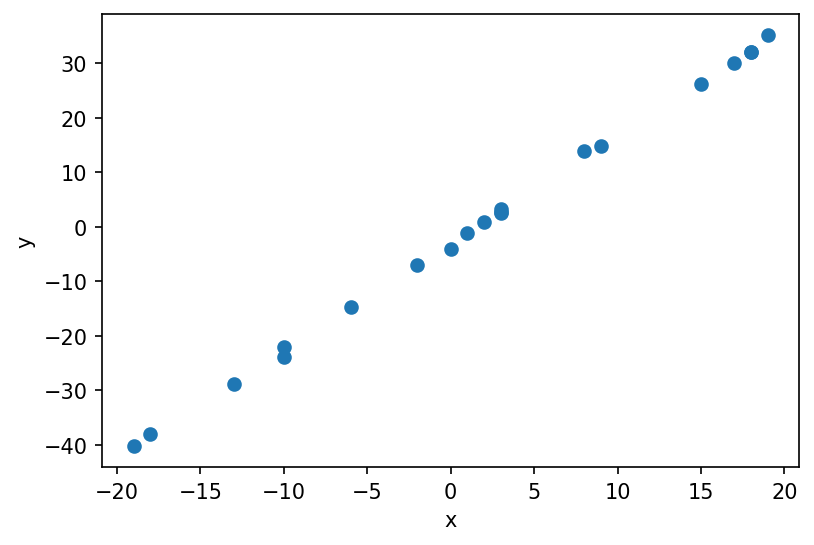

In [ ]:
import random
random.seed(42)
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150

def yf(x):
  return 2*x - 3 + (np.random.rand(len(x))-0.5)*2

x = np.random.randint(-20, 20, 20)
y = yf(x)

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
# reshape Y
Y = np.reshape(y, (-1,1))
# add bias
X = np.array(list(zip(x, np.ones_like(x))))

In [ ]:
# forward
def forward(theta, X):
  Y_hat = np.matmul(X, theta)
  return Y_hat

# loss
def mse(Y_hat, Y):
  return np.mean((Y_hat - Y)**2)

# derrivative
def gradient(X, Y, Y_hat):
  return (2*np.matmul((Y_hat-Y).T, X)/len(Y)).T

In [ ]:
class GD():
  def __init__(self, lr):
    self.lr = lr

  def backward(self, theta, gradients):
    theta = theta - self.lr*(gradients)
    return theta

In [ ]:
def train_step(X, Y, theta, optimizer):
  # forward
  Y_hat = forward(theta, X)
  loss = mse(Y_hat, Y)
  dLdTheta = gradient(X, Y, Y_hat)
  theta = optimizer.backward(theta, dLdTheta)
  return theta, loss, dLdTheta

In [ ]:
# training
def train(X, Y, theta0, optimizer, num_epochs):
  losses = []
  thetas = []
  dLdThetas = []
  theta = theta0
  
  for epoch in range(num_epochs):
    theta, loss, dLdTheta = train_step(X, Y, theta,optimizer)
    thetas.append(theta)
    losses.append(loss)
    dLdThetas.append(dLdTheta)
  return losses, thetas, dLdThetas

In [ ]:
def plot_losses(losses):
  plt.plot(losses)
  plt.ylim([-1, 20])
  ax = plt.gca()
  msg = f'Final loss: {round(losses[-1], 3)}'
  plt.text(0.99, 0.1, msg,
      horizontalalignment='right',
      verticalalignment='top',
      transform = ax.transAxes)
  plt.xlabel("iteration")
  plt.ylabel("loss")
  plt.show()

In [ ]:
def plot_thetas(thetas, losses):
  grid_size = 100
  thetas = np.array(thetas)
  theta1s = np.linspace(0, 4, grid_size)
  theta2s = np.linspace(1, -7, grid_size)
  Z = np.zeros((grid_size, grid_size))
  for i in range(grid_size):
    for j in range(grid_size):
      theta = np.array([[theta1s[i]], [theta2s[j]]])
      Y_hat = forward(theta, X)
      loss = mse(Y_hat, Y)
      Z[i,j] = loss
  plt.contourf(theta1s, theta2s, Z,  extend='both', alpha=0.3, antialiased=True)
  plt.plot(thetas[:, 0], thetas[:, 1])
  plt.plot(2, -3, "rx", markersize=10)
  theta0 = thetas[-1,0][0]
  theta1 = thetas[-1,1][0]
  msg = f'  Final thetas: {round(theta0, 3), round(theta1, 3)}'
  plt.text(theta0, theta1, msg)
  plt.xlabel(r'$\theta_1$')
  plt.ylabel(r'$\theta_2$')
  plt.show()

In [ ]:
theta0 = np.random.rand(2, 1)
num_epochs = 500
lr = 0.001

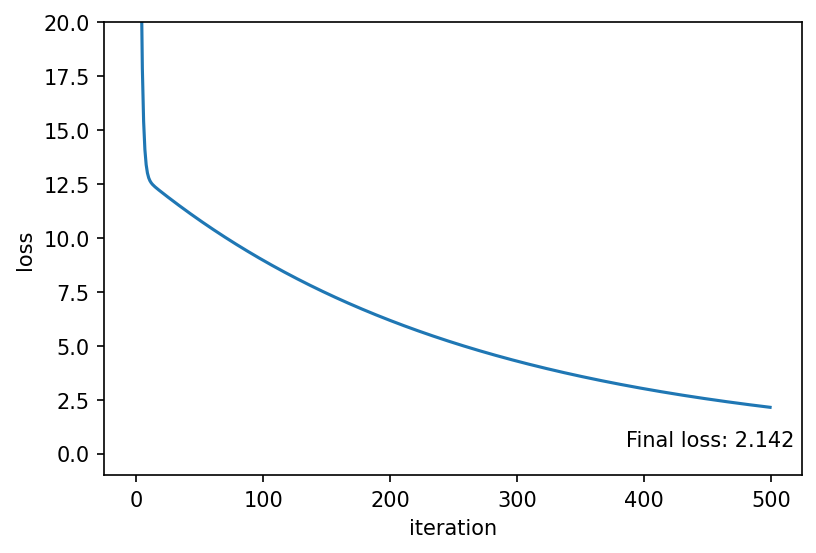

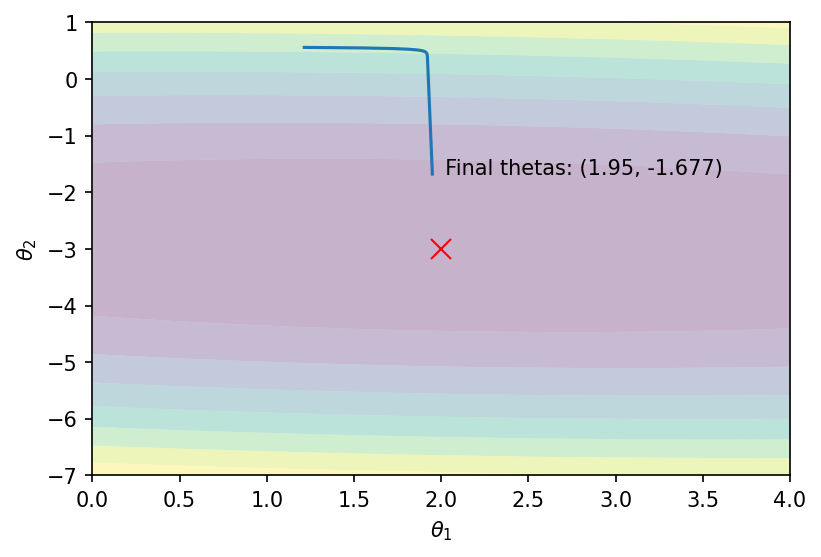

In [ ]:
optimizer = GD(lr = lr)
losses, thetas, dLdThetas = train(X, Y, theta0, optimizer=optimizer, num_epochs=num_epochs)
plot_losses(losses)
plot_thetas(thetas, losses)

# Stochastic Gradient Descent

In [ ]:
# train per mini batch
def train_mini_batch(X, Y, theta0, optimizer, num_epochs, batch_size):
  batches = len(X)//batch_size
  indices = np.arange(len(X))
  losses = []
  thetas = []
  dLdThetas = []
  theta = theta0
  for e in range(num_epochs):
    # shuffle
    np.random.shuffle(indices)
    for i in range(batches):
      start = i*batch_size
      stop = start + batch_size
      indices_b = indices[start:stop] 
      X_b = X[indices_b]
      Y_b = Y[indices_b]
      theta, loss, dLdTheta = train_step(X_b, Y_b, theta,optimizer)
      thetas.append(theta)
      losses.append(loss)
      dLdThetas.append(dLdTheta)
  return losses, thetas, dLdThetas



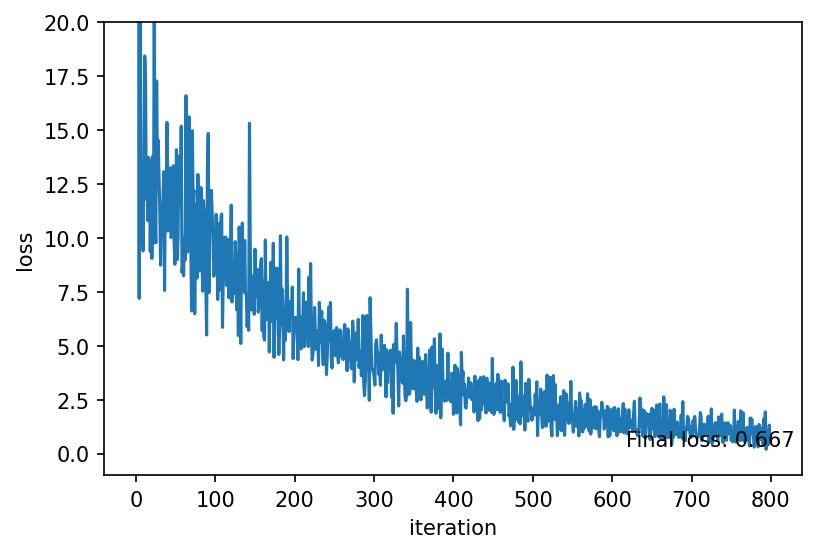

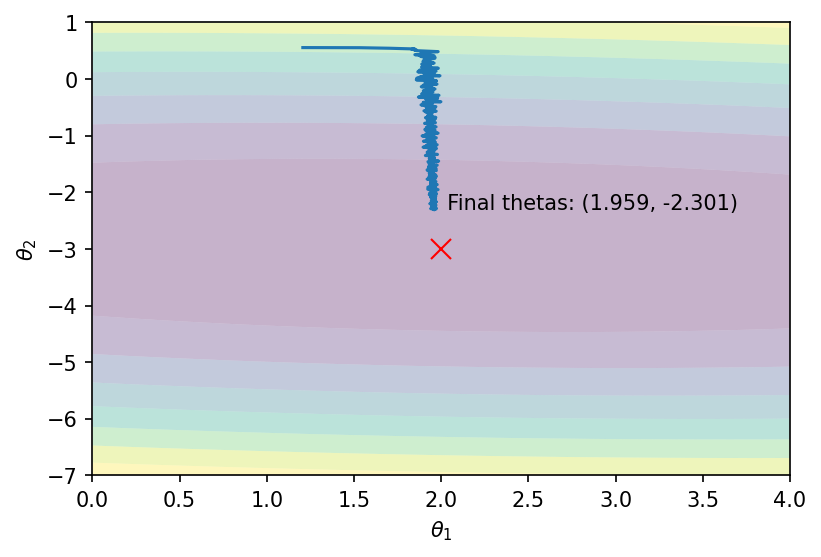

In [ ]:
losses, thetas, dLdThetas = train_mini_batch(X, Y, theta0, optimizer=optimizer, num_epochs=num_epochs-300, batch_size = 5)
plot_losses(losses)
plot_thetas(thetas, losses)

# Momentum

In [ ]:
class Momentum():
  def __init__(self, lr, moment, nesterov=False):
    self.lr = lr
    self.moment = moment
    self.first_step = True
    self.nesterov = nesterov

  def backward(self, theta, gradients):
    if self.first_step:
      self.v = np.zeros_like(theta)
      self.first_step = False

    if not self.nesterov:
      self.v = self.moment*self.v + self.lr * gradients
      theta = theta - self.v
    else:
      self.v = self.moment*self.v + gradients
      theta = theta - self.lr * self.v
    
    return theta

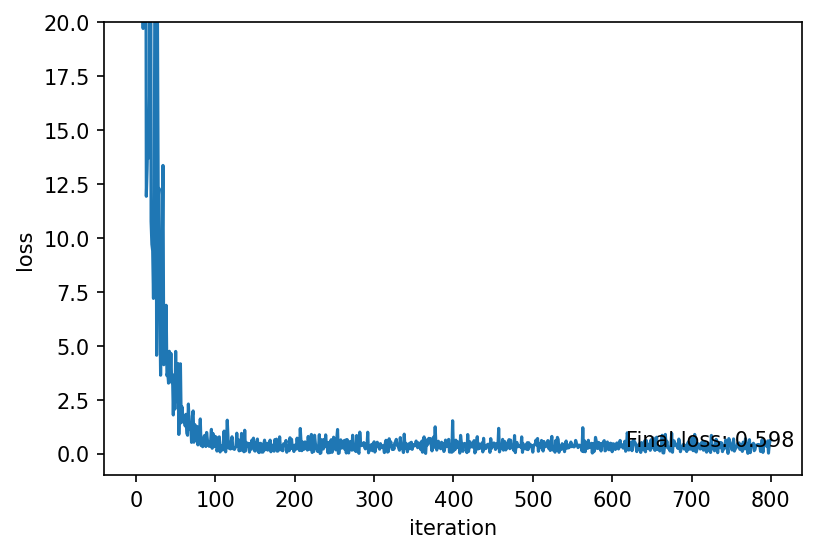

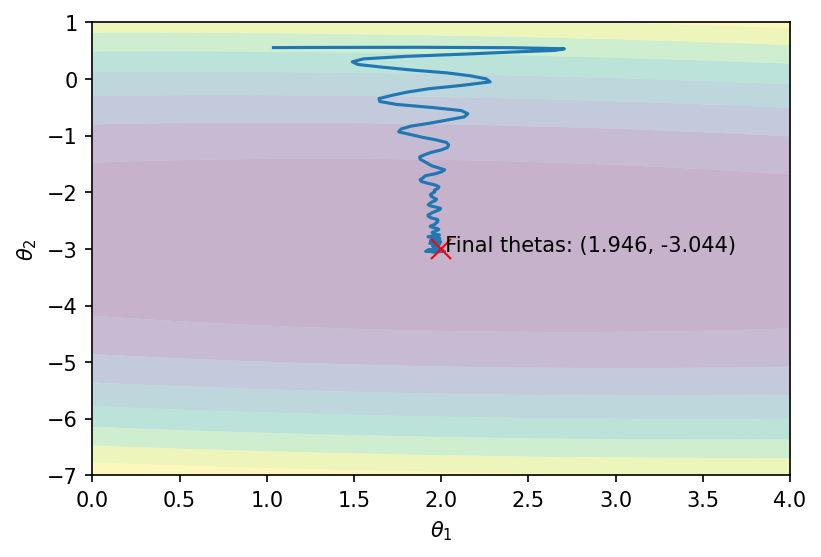

In [ ]:
optimizer = Momentum(lr = lr, moment=0.9)
losses, thetas, dLdThetas = train_mini_batch(X, Y, theta0, optimizer=optimizer, num_epochs=num_epochs-300, batch_size = 5)
plot_losses(losses)
plot_thetas(thetas, losses)

## Nesterov

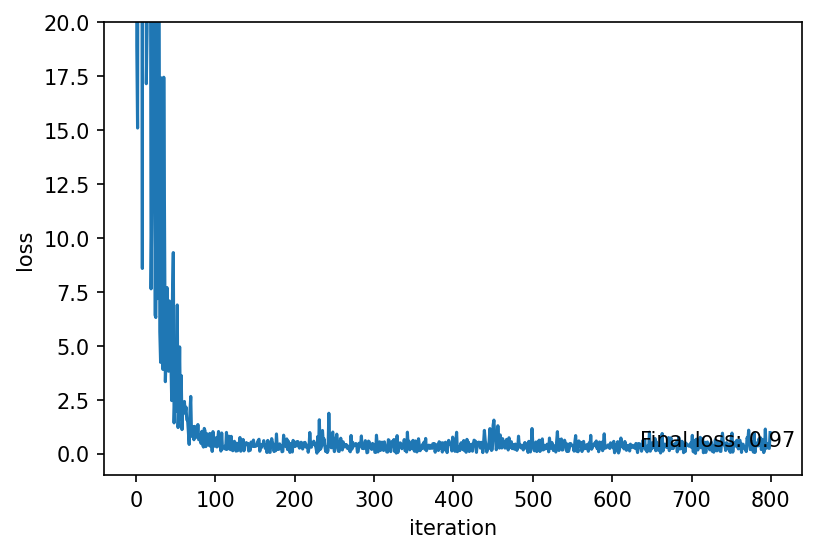

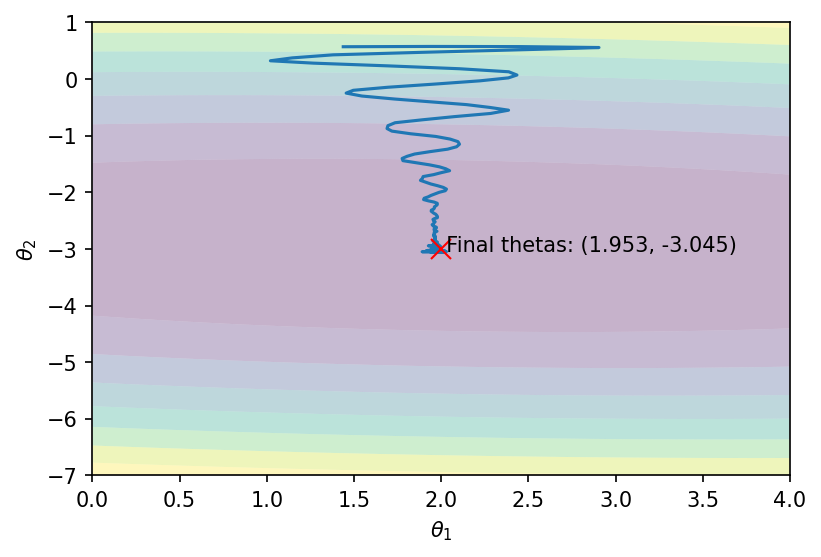

In [ ]:
optimizer = Momentum(lr = lr, moment=0.9, nesterov=True)
losses, thetas, dLdThetas = train_mini_batch(X, Y, theta0, optimizer=optimizer, num_epochs=num_epochs-300, batch_size = 5)
plot_losses(losses)
plot_thetas(thetas, losses)

## Variable Learning Rates

In [ ]:
class VariableLR():
  def __init__(self, lr, moment, nesterov=False, warmup_iters=0, steps=None, gamma=0.5):
    self.lr = lr
    self.moment = moment
    self.nesterov = nesterov
    self.warmup_iters = warmup_iters
    self.steps = steps
    self.gamma = gamma
    self.iter = 0
    self.lrs = []
    self.first_step = True

  def backward(self, theta, gradients):
    # steps
    if self.iter in self.steps:
      self.lr = self.lr*self.gamma

    # warming up
    self.iter += 1
    if self.warmup_iters!=0 and self.iter < self.warmup_iters:
      lr = (self.iter/self.warmup_iters)*self.lr
    else:
      lr = self.lr    

    self.lrs.append(lr)

    if self.first_step:
      self.v = np.zeros_like(theta)
      self.first_step = False

    if not self.nesterov:
      self.v = self.moment*self.v + lr * gradients
      theta = theta - self.v
    else:
      self.v = self.moment*self.v + gradients
      theta = theta - lr * self.v
    
    return theta

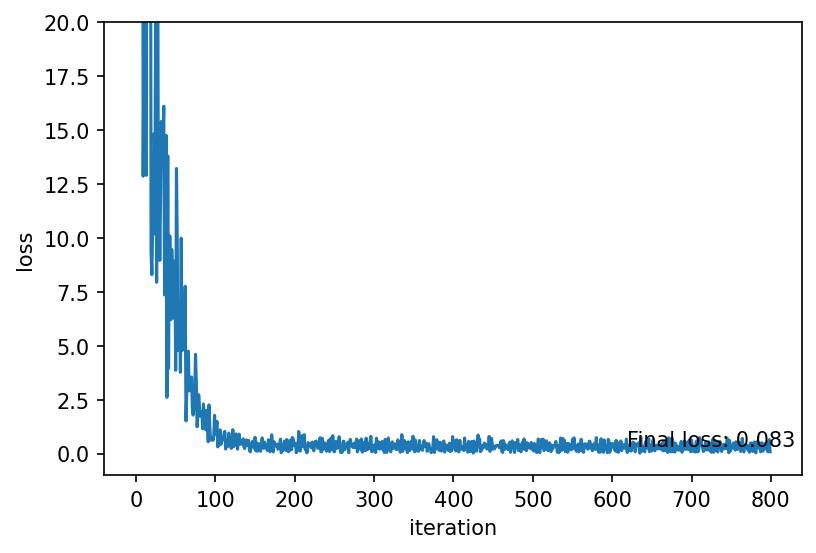

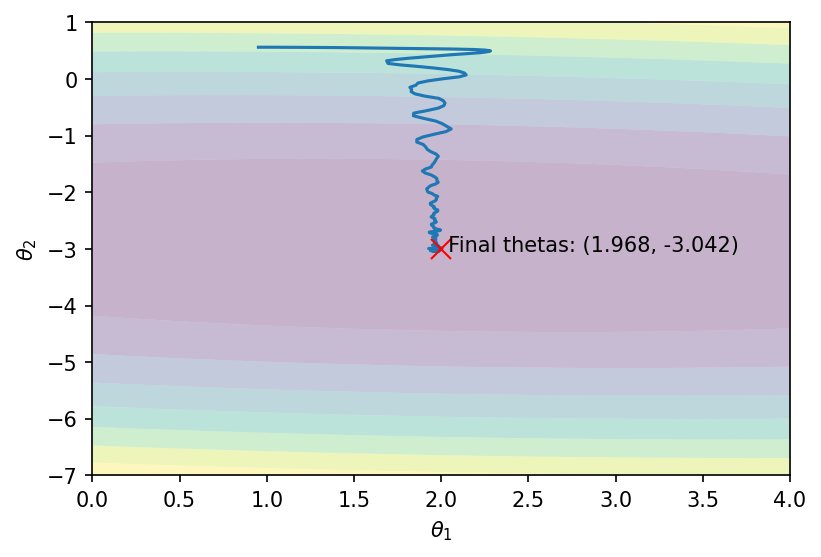

In [ ]:
optimizer = VariableLR(lr = lr, moment=0.9, nesterov=False, warmup_iters=50, steps=(300, 500))
losses, thetas, dLdThetas = train_mini_batch(X, Y, theta0, optimizer=optimizer, num_epochs=num_epochs-300, batch_size = 5)
plot_losses(losses)
plot_thetas(thetas, losses)

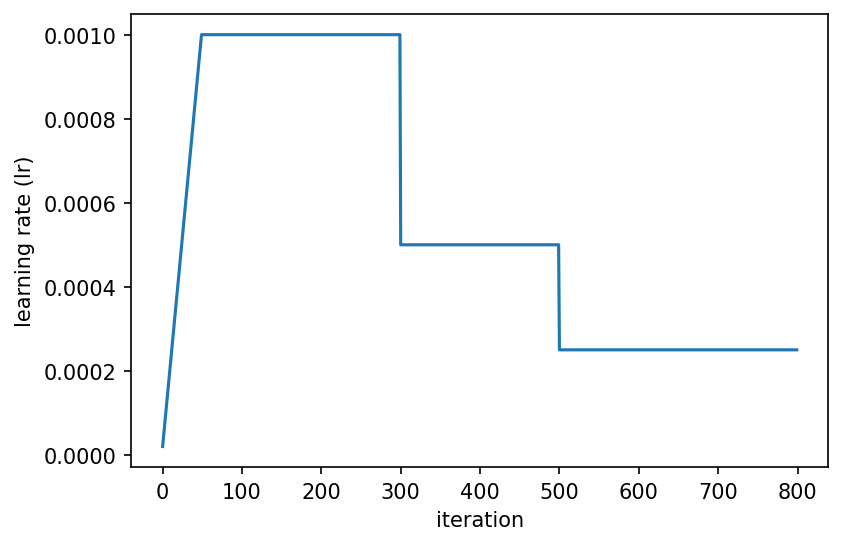

In [ ]:
plt.plot(optimizer.lrs)
plt.xlabel("iteration")
plt.ylabel("learning rate (lr)")
plt.show()